# SqueezeNet

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

Optimization Steps (didn't converge initially)
 1. added MSR initialization (Epoch [100/100] Train Loss: 0.1352, Train Acc: 95.27% Test/Val Loss: 1.1394, Test/Val Acc: 75.05%)
 2. added batchnorm (Epoch [100/100] Train Loss: 0.0758, Train Acc: 97.39% Test/Val Loss: 0.8656, Test/Val Acc: 80.68%)
 3. added dropout b/w fire modules

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.ao.quantization import QuantStub, DeQuantStub
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from collections import OrderedDict

## Training

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

After these definitions we will train the model.

In [18]:
import math
class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand_planes):
        super(Fire, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(squeeze_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(expand_planes)
        self.conv3 = nn.Conv2d(squeeze_planes, expand_planes, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(expand_planes)
        self.relu2 = nn.ReLU(inplace=True)

        # MSR initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        out1 = self.bn2(self.conv2(x))
        out2 = self.bn3(self.conv3(x))
        out = torch.cat([out1, out2], 1)
        out = self.relu2(out)
        return out

class SqueezeNetCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(SqueezeNetCIFAR10, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()

        self.conv1 = nn.Conv2d(3, 96, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2, 2)  # 32 -> 16

        self.fire2 = Fire(96, 16, 64)
        self.fire3 = Fire(128, 16, 64)
        self.fire4 = Fire(128, 32, 128)
        self.dropout4 = nn.Dropout(p=0.2)
        self.maxpool2 = nn.MaxPool2d(2, 2)  # 16 -> 8

        self.fire5 = Fire(256, 32, 128)
        self.fire6 = Fire(256, 48, 192)
        self.fire7 = Fire(384, 48, 192)
        self.fire8 = Fire(384, 64, 256)
        self.dropout8 = nn.Dropout(p=0.2)
        self.maxpool3 = nn.MaxPool2d(2, 2)  # 8 -> 4

        self.fire9 = Fire(512, 64, 256)
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.dropout_final = nn.Dropout(p=0.5)
        self.avg_pool = nn.AvgPool2d(4)

    def forward(self, x):
        x = self.quant(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool1(x)

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.dropout4(x)
        x = self.maxpool2(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.dropout8(x)
        x = self.maxpool3(x)

        x = self.fire9(x)
        x = self.conv10(x)
        x = self.dropout_final(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dequant(x)
        return x
    
    def load_model(self, path='squeezenet_cifar10.pth',device='cpu'):
        state_dict = torch.load(path,map_location=device)

        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[len('module.'):]
            new_state_dict[k] = v

        self.load_state_dict(new_state_dict)
        self.to(device)
        self.eval()

        print(f"Model loaded from {path}")
        # print(self)

    def save_model(self, path='squeezenet_cifar10.pth'):
        torch.save(self.state_dict(), path)
        print(f"Model saved to {path}")


## Load the Dataset

In this cell we define a function to load our dataset.

In [23]:
from torchvision.transforms.autoaugment import AutoAugment, AutoAugmentPolicy

def load_dataset(path='./data', batch_size=64):
  print("Loading the CIFAR10 dataset")

  test_transform = transforms.Compose([
      transforms.ToTensor(), # scale RGB 0-255 to 0-1
      # normalize with known mean and std deviation of the CIFAR10 dataset
      transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010))
      ])
  
  transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.AutoAugment(policy=AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),
  ])

  # get training data
  train_dataset = datasets.CIFAR10(root=path, train=True, download=True, transform=transform)
  # get test data
  test_dataset = datasets.CIFAR10(root=path, train=False, download=True, transform=test_transform)
  # load the training data
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  # load the test data
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  print(f"Loaded train data: {len(train_loader.dataset)} total samples, {len(train_loader)} batches\n"
      f"Loaded test data: {len(test_loader.dataset)} total samples, {len(test_loader)} batches")

  return train_loader, test_loader

In [24]:
train_loader, test_loader = load_dataset()

Loading the CIFAR10 dataset
Loaded train data: 50000 total samples, 782 batches
Loaded test data: 10000 total samples, 157 batches


## Train the model

In the cells below we define a function to visualize our training and train our model

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_metrics(metrics):
  train_losses = metrics.get('train_loss',None)
  test_losses = metrics.get('test_loss',None)
  train_accs = metrics.get('train_acc',None)
  test_accs = metrics.get('test_acc',None)

  epochs = range(1, len(train_losses) + 1)

  plt.figure(figsize=(12, 5))

  # Loss Graph
  plt.subplot(1, 2, 1)
  if train_losses:
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  if test_losses:
    plt.plot(epochs, test_losses, label='Test Loss', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training vs Test Loss')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  # Accuracy Graph
  plt.subplot(1, 2, 2)
  if train_accs:
    plt.plot(epochs, train_accs, label='Train Accuracy', marker='o')
  if test_accs:
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='s')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title('Training vs Test Accuracy')
  plt.legend()
  plt.grid(True, linestyle='--', alpha=0.6)

  plt.tight_layout()
  plt.show()

def plot_weight_histogram(model, bins=50):
  all_weights = []

  for name, module in model.named_modules():
      if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
          weights = module.weight.detach().cpu().numpy().flatten()
          all_weights.extend(weights)

  all_weights = np.array(all_weights)

  plt.figure(figsize=(8,6))
  plt.hist(all_weights, bins=bins, color='skyblue', edgecolor='black')
  plt.title("Weight Distribution Histogram")
  plt.xlabel("Weight Value")
  plt.ylabel("Frequency")
  plt.grid(True, alpha=0.3)
  plt.show()

In [28]:
def train_model(model,train_loader,test_loader,train=True,test=True,device='cpu',epochs=10,lr=1e-3):
  model.to(device)
  metrics = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

  # TRAINING LOOP
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

  for e in range(epochs):
    print(f"Epoch [{e+1}/{epochs}] ",end='')
    if train:
      model.train()
      train_loss, total_examples, correct = 0.0, 0, 0

      for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # forward pass
        loss = criterion(outputs,labels) # get loss from cost function
        loss.backward() # backward propagation
        optimizer.step() # update gradients

        # train_loss += loss.item() # track total loss up to this point
        train_loss += loss.item() * labels.size(0)
        _, pred_ind = outputs.max(1) # get index of prediction (highest value)
        total_examples += labels.size(0) # update count for this epoch with batch size
        correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

    #   train_loss /= len(train_loader) # get average per batch
      train_loss /= total_examples # get average per example
      train_acc = 100.0 * correct / total_examples

      metrics["train_loss"].append(train_loss)
      metrics["train_acc"].append(train_acc)

      print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% ",end='')

      # VALIDATION/TEST
    if test:
      model.eval()
      test_loss, total_examples, correct = 0.0, 0, 0

      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs) # forward pass
          loss = criterion(outputs,labels) # get loss from cost function
          test_loss += loss.item() # update loss
          _, pred_ind = outputs.max(1) # get index of prediction (highest value)
          total_examples += labels.size(0) # update count for this epoch with batch size
          correct += pred_ind.eq(labels).sum().item() # return count of correct predictions

      test_loss /= len(test_loader)
      test_acc = 100.0 * correct / total_examples

      metrics["test_loss"].append(test_loss)
      metrics["test_acc"].append(test_acc)

      print(f"Test/Val Loss: {test_loss:.4f}, Test/Val Acc: {test_acc:.2f}%")

  return metrics

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

model_fp32 = SqueezeNetCIFAR10()

model_fp32.load_model('squeezenet_bn_cifar10_fp32.pth')

Device=cuda
Model loaded from squeezenet_bn_cifar10_fp32.pth


In [ ]:
train, test = True, True
epochs = 100
fp32_metrics = train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

In [ ]:
model_fp32.save_model("squeezenet_dataaug_cifar10_fp32.pth")

Model saved to squeezenet_bn_cifar10_fp32.pth


In [ ]:
plot_metrics(fp32_metrics)

In [ ]:
plot_weight_histogram(model_fp32)

## Pruning

Next we will attempt to prune the model

In [ ]:
# model = SqueezeNetCIFAR10()
# model.load_model("squeezenet_bn_cifar10_fp32.pth", device='cpu')
# model.train()

Model loaded from squeezenet_bn_cifar10_fp32.pth


SqueezeNetCIFAR10(
  (quant): QuantStub()
  (dequant): DeQuantStub()
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fire2): Fire(
    (conv1): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
  )
  (fire3): Fire(
    (conv1): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    

In [ ]:
# import torch.nn.utils.prune as prune

# parameters_to_prune = []
# for name, module in model.named_modules():
#     if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
#         parameters_to_prune.append((module, "weight"))

# prune.global_unstructured(
#     parameters_to_prune,
#     pruning_method=prune.L1Unstructured,
#     amount=0.3, # 30% of weights
# )

# for name, module in model.named_modules():
#     if hasattr(module, "bias") and module.bias is not None:
#         prune.l1_unstructured(module, name="bias", amount=0.1)

In [ ]:
# train, test = True, True
# epochs = 10
# pruned_metrics = train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/10] Train Loss: 1.1816, Train Acc: 57.43% Test/Val Loss: 1.1232, Test/Val Acc: 59.64%
Epoch [2/10] Train Loss: 0.9045, Train Acc: 67.89% Test/Val Loss: 0.8630, Test/Val Acc: 69.67%
Epoch [3/10] Train Loss: 0.7411, Train Acc: 74.00% Test/Val Loss: 0.7525, Test/Val Acc: 73.40%
Epoch [4/10] Train Loss: 0.6355, Train Acc: 77.77% Test/Val Loss: 0.7692, Test/Val Acc: 73.50%
Epoch [5/10] Train Loss: 0.5615, Train Acc: 80.31% Test/Val Loss: 0.8303, Test/Val Acc: 71.88%
Epoch [6/10] Train Loss: 0.4971, Train Acc: 82.58% Test/Val Loss: 0.6911, Test/Val Acc: 76.46%
Epoch [7/10] Train Loss: 0.4419, Train Acc: 84.52% Test/Val Loss: 0.6483, Test/Val Acc: 78.60%
Epoch [8/10] Train Loss: 0.3973, Train Acc: 86.06% Test/Val Loss: 0.6250, Test/Val Acc: 79.36%
Epoch [9/10] Train Loss: 0.3644, Train Acc: 87.29% Test/Val Loss: 0.6568, Test/Val Acc: 78.18%
Epoch [10/10] Train Loss: 0.3271, Train Acc: 88.56% Test/Val Loss: 0.6836, Test/Val Acc: 77.66%


In [ ]:
# for name, module in model.named_modules():
#     if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
#         # remove weight reparametrization
#         prune.remove(module, 'weight')

#     if hasattr(module, "bias") and module.bias is not None:
#         try:
#             prune.remove(module, 'bias')
#         except ValueError:
#             pass

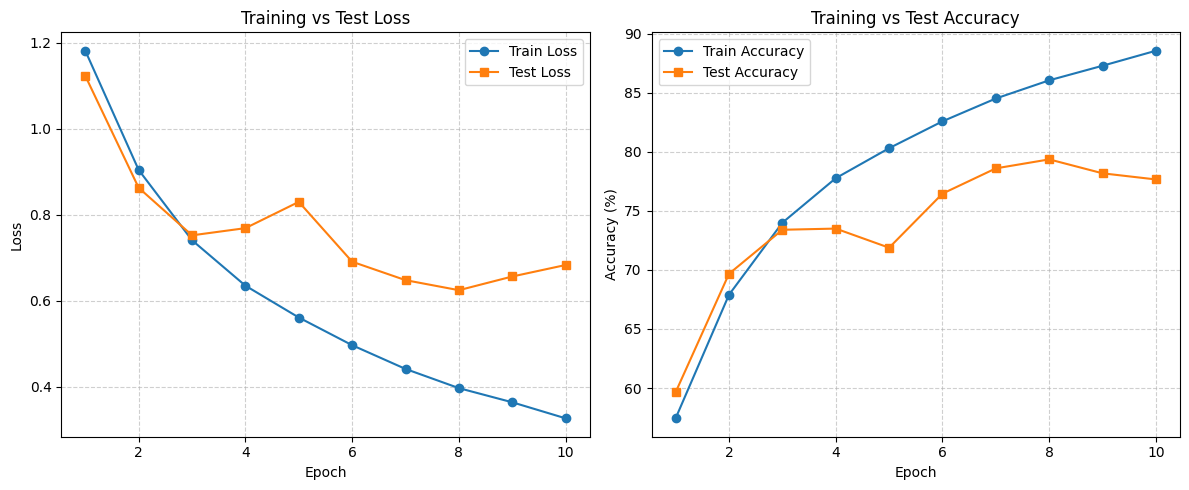

In [ ]:
# plot_metrics(pruned_metrics)

In [ ]:
# torch.save(model.state_dict(), "squeezenet_pruned_fp32.pth")

## Quantization Aware Training

Next we will use QAT to prepare the model for quantization and analyze the effects. At the end we can see that QAT led to slightly higher accuracy compared to quantization without.

In [ ]:
# import torch
# from torch.ao.quantization import get_default_qat_qconfig
# from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx

# model_qat = SqueezeNetCIFAR10()
# model_qat.load_model("squeezenet_bn_cifar10_fp32.pth", device='cpu')
# model_qat.eval()

# # example input for FX tracing
# example_inputs = (torch.randn(1, 3, 32, 32, device='cpu'),)

# # QAT config dictionary
# qconfig_dict = {"": get_default_qat_qconfig('fbgemm')}  # default 8-bit symmetric QAT

# # Prepare the model for QAT
# model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict, example_inputs=example_inputs)

# model_qat_prepared.to(device)
# model_qat_prepared.train()  # ready for QAT fine-tuning

Model loaded from squeezenet_bn_cifar10_fp32.pth


C:\Users\K\AppData\Local\Temp\ipykernel_8252\3924880218.py:16: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict, example_inputs=example_inputs)
c:\Users\K\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\ao\quantization\quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is dep

GraphModule(
  (activation_post_process_0): FusedMovingAvgObsFakeQuantize(
    fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.quint8, quant_min=0, quant_max=127, qscheme=torch.per_tensor_affine, reduce_range=True
    (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
  )
  (conv1): ConvBnReLU2d(
    3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0'), observer_enabled=tensor([1], device='cuda:0'), scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0', dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
  

In [ ]:
# train, test = True, True
# epochs = 20
# qat_metrics = train_model(model=model_qat_prepared,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/20] Train Loss: 0.0916, Train Acc: 96.81% Test/Val Loss: 0.8246, Test/Val Acc: 81.00%
Epoch [2/20] Train Loss: 0.0801, Train Acc: 97.22% Test/Val Loss: 0.8626, Test/Val Acc: 80.38%
Epoch [3/20] Train Loss: 0.0877, Train Acc: 96.99% Test/Val Loss: 0.8046, Test/Val Acc: 81.27%
Epoch [4/20] Train Loss: 0.0857, Train Acc: 96.98% Test/Val Loss: 0.7726, Test/Val Acc: 81.59%
Epoch [5/20] Train Loss: 0.0867, Train Acc: 97.03% Test/Val Loss: 0.8382, Test/Val Acc: 80.31%
Epoch [6/20] Train Loss: 0.0851, Train Acc: 97.08% Test/Val Loss: 0.8354, Test/Val Acc: 80.67%
Epoch [7/20] Train Loss: 0.0843, Train Acc: 97.04% Test/Val Loss: 0.8354, Test/Val Acc: 80.63%
Epoch [8/20] Train Loss: 0.0891, Train Acc: 96.93% Test/Val Loss: 0.8506, Test/Val Acc: 80.51%
Epoch [9/20] Train Loss: 0.0812, Train Acc: 97.12% Test/Val Loss: 0.8145, Test/Val Acc: 80.80%
Epoch [10/20] Train Loss: 0.0893, Train Acc: 96.84% Test/Val Loss: 0.8496, Test/Val Acc: 80.54%
Epoch [11/20] Train Loss: 0.0904, Train Acc: 96.8

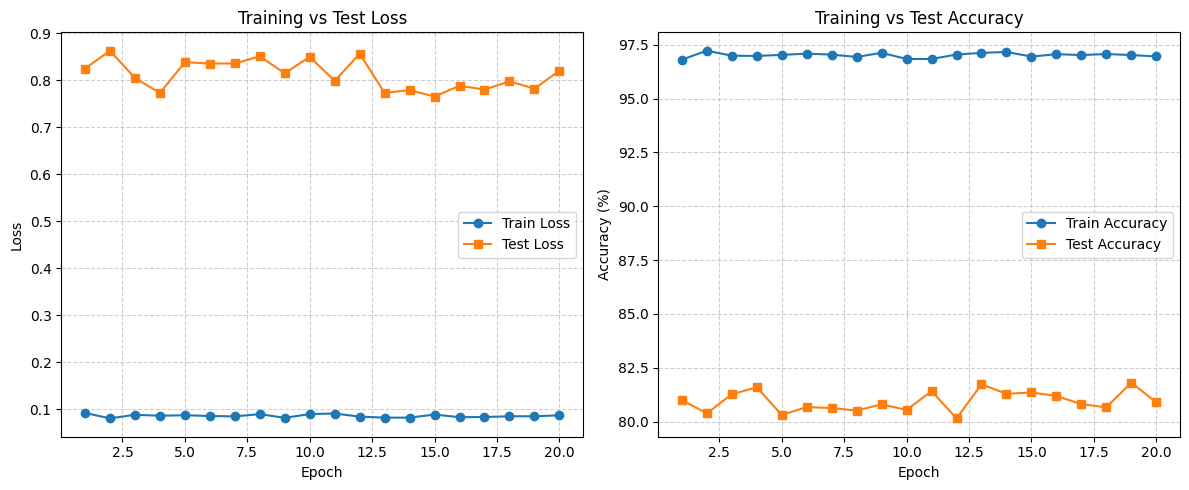

In [ ]:
# plot_metrics(qat_metrics)

In [ ]:
# # convert to INT8
# model_qat_prepared.eval()
# model_int8 = convert_fx(model_qat_prepared.cpu())
# torch.save(model_int8.state_dict(), "squeezenet_int8_qat.pth")
# # model_int8.load_state_dict(torch.load("squeezenet_int8_qat.pth"))
# # model_int8.eval()

C:\Users\K\AppData\Local\Temp\ipykernel_8252\1725404078.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = convert_fx(model_qat_prepared.cpu())


In [ ]:
# def evaluate(model, test_loader):
#     model.eval()
#     model.to('cpu')
#     correct, total = 0, 0

#     with torch.no_grad():
#         for images, labels in test_loader:
#             images, labels = images.to('cpu'), labels.to('cpu')
#             outputs = model(images)
#             _, pred = outputs.max(1)
#             correct += pred.eq(labels).sum().item()
#             total += labels.size(0)

#     acc = 100.0 * correct / total
#     return acc

# acc = evaluate(model_int8,test_loader)
# print(f"INT8 with QAT Test Accuracy: {acc}%")

INT8 with QAT Test Accuracy: 80.59%


In [ ]:
# from torch.ao.quantization import get_default_qconfig
# from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

# model_fp32 = SqueezeNetCIFAR10()
# model_fp32.load_model("squeezenet_bn_cifar10_fp32.pth", device='cpu')
# model_fp32.eval()

# example_inputs = (torch.randn(1, 3, 32, 32),)

# qconfig_dict = {"": get_default_qconfig('fbgemm')}

# model_ptq_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs)

# calibration_loader = DataLoader(train_loader.dataset, batch_size=32, shuffle=False)

# model_ptq_prepared.eval()

# # calibrate model by observing activations
# with torch.inference_mode():
#     for i, (x, _) in enumerate(calibration_loader):
#         model_ptq_prepared(x)
#         if i == 20:   # 20–100 batches is typical
#             break

Model loaded from squeezenet_bn_cifar10_fp32.pth


C:\Users\K\AppData\Local\Temp\ipykernel_8252\1336839154.py:12: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_ptq_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs)
c:\Users\K\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\ao\quantization\quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will n

In [ ]:
# model_int8_ptq = convert_fx(model_ptq_prepared)
# acc = evaluate(model_int8_ptq,test_loader)
# print(f"INT8 Wihtout QAT Test Accuracy: {acc}%")

C:\Users\K\AppData\Local\Temp\ipykernel_8252\1888138913.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8_ptq = convert_fx(model_ptq_prepared)


INT8 Wihtout QAT Test Accuracy: 80.3%
